# Visually Comparing Climate Models



---
### Summary

In this notebook, I will be comparing three climate reanalysis models:

* NCEP-DOE Reanalysis 2: Surface
* ERA5
* CMIP5

I will be looking at the following variables:

* Mean Sea Level Pressure (CMIP5, ERA5, NCEP)
* Surface Pressure (ERA5, NCEP)

I will be trying to user RBIG in order to assess how similar these models are. I'll be looking at the following IT measures. If these climate models are that similar, then they should exhibit similar IT measures.

---
### Preprocessing Steps

**Regridded Spatially**

* The ERA5 had the coarsest spatial resolution (2.5 x 2.5). 
* I regridded the NCEP from (0.25 x 0.25) to (2.5 x 2.5).
* I regridded the CMIP5 from (2 x 2.5) to (2.5 x 2.5).

**Temporal Resolution**

* ERA5 and NCEP go from 1980-2019
* CMIP5 goes from 2006-2018
* For comparing ERA5 vs CMIP5 and NCEP vs CMIPF, I found the same time components


---
### Measures

I'm measuring the following:

* Entropy - expected uncertainty
* Total Correlation - amount of redundant information between features
* Mutual Information - amount of information shared between variables


---
### Data

**Inputs**

I'm taking each year as is. Each spatial location is a sample and each year is a feature. My inputs are:

$$X \in \mathbb{R}^{\text{spatial } \times \text{ month}}$$

**Outputs**

All my information theory measures are in nats. They are scalars.

---
### Hypothesis

Simple: The ERA5 and the NCEP model should be more similar than the CMIP5 model compared to each of them. 

---
## Data - Climate Models

In [3]:
!ls /home/emmanuel/projects/2020_rbig_rs/notebooks/climate/../../

LICENSE    data		    environment_dev.yml  notebooks   reports   src
README.md  environment.yml  environment_gpu.yml  references  setup.py


In [2]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../../../"
sys.path.insert(0, f'{source_path}')

# Import RBIG Helper
# from src.models.train_models import run_rbig_models

# ESDC tools
sys.path.insert(0, f'/home/emmanuel/code/py_esdc')
# from esdc.preprocessing import normalize_temporal
from pathlib import Path


import cdsapi
from zipfile import ZipFile
import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

# Visualization Tools
from src.data.climate.loader import ResultsLoader
# from src.visualization.climate import PlotResults
from src.visualization.climate.local import plot_diff, plot_individual, plot_individual_diff, plot_individual_all

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use(['seaborn-poster', 'fivethirtyeight'])

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Entropy

In [3]:


def get_entropy_results(base_model: str, results: str='interim', model: str='rcp')-> pd.DataFrame:
    base_path = '/home/emmanuel/projects/2020_rbig_rs/data/climate/'
    
    # CHECK: RCP or AMIP
    if model == 'rcp':
        data_path = f"/rcp/local/individual/"
        ext = 'v3'
    elif model == 'amip':
        data_path = f"/amip/local/individual/"
        ext = 'v4'
    else:
        raise ValueError('Unrecognized model: ', model)
        
#     print(base_path + results + data_path)
    path = Path(base_path + results + data_path)
    
    if base_model == 'ncep':
        filename_pattern = 'ncep_*_'
        
    elif base_model == 'era5':
        filename_pattern = 'era5_*_'
        
    else:
        raise ValueError('Unrecognized base model:', base_model)
    
    df_from_each_file = [pd.read_csv(f, index_col=0) for f in path.rglob(filename_pattern + ext + '.csv')]
    results_df   = pd.concat(df_from_each_file, ignore_index=True)
    return results_df

In [96]:
from typing import List

def post_processing_entropy(df: pd.DataFrame, model: str='amip', exclude: List[str]=['inmcm4'], normalized: bool=False)-> pd.DataFrame:
    
    # exclude models
    df = df[~df['cmip'].isin(exclude)]
    
    # divide by the spatial resolution

    if model == 'amip':
        banned_cmip_dates = [
            '1979-01-16 12:00:00', 
            '2009-01-16 12:00:00', 
            '2010-01-16 12:00:00'
        ]
        banned_base_dates = ['1979-01-01', '2010-01-01']
        banned_out_dates = [
         '2006-02-01',
         '2011-01-01',
         '2012-01-01',
         '2013-01-01',
         '2014-01-01',
         '2015-01-01',
         '2016-01-01',
         '2017-01-01',
         '2018-01-01',
         '2019-01-01'
        ]
    elif model == 'rcp':
        banned_cmip_dates = []
        banned_base_dates = []
        banned_out_dates = []
    elif model == 'none':
        banned_out_dates = []
        banned_cmip_dates = []
        banned_base_dates = []
    else:
        raise ValueError('Unrecognized dataset')
    # divide by the spatial resolution
    if normalized:
        df['h_base'] = df['h_base'] / (df['spatial'] ** 2)
        df['h_cmip'] = df['h_cmip'] / (df['spatial'] ** 2)
    
    df = df[~df.cmip_time.isin(banned_cmip_dates)]
    df = df[~df.base_time.isin(banned_base_dates)]
    df = df[~df.base_time.isin(banned_out_dates)]
    return df

### NCEP - Individual IT Measures

In [6]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/rcp/local/individual/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/rcp/local/individual/"

In [7]:
# extract results
results_df = get_entropy_results('ncep', 'interim', 'amip')

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1'
]
results_df = post_processing_entropy(results_df, exclude=exclude)



/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [106]:
results_df.cmip.unique().tolist()

['mpi_esm_lr', 'noresm1_m', 'mpi_esm_mr', 'access1_0', 'ipsl_cm5a_mr']

In [26]:
results_df.head()

base   base_time    cmip            cmip_time    h_base    h_cmip  spatial  \
0  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.173002  1.263623      1.0   
1  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.177404  1.269881      1.0   
2  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.186812  1.277439      1.0   
3  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.183485  1.273517      1.0   
4  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.193985  1.280803      1.0   

   subsample    t_base    t_cmip  tc_base  tc_cmip  trial variable  
0    50000.0  1.319296  1.451097      0.0      0.0    0.0      psl  
1    50000.0  1.351144  1.327829      0.0      0.0    1.0      psl  
2    50000.0  1.282283  1.448870      0.0      0.0    2.0      psl  
3    50000.0  1.317563  1.319149      0.0      0.0    3.0      psl  
4    50000.0  1.315317  1.527269      0.0      0.0    4.0      psl

In [27]:
results_df[results_df['cmip'] == 'inmcm4'].unique()

base   base_time    cmip            cmip_time    h_base    h_cmip  spatial  \
0  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.173002  1.263623      1.0   
1  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.177404  1.269881      1.0   
2  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.186812  1.277439      1.0   
3  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.183485  1.273517      1.0   
4  ncep  1979-01-01  inmcm4  1979-01-16 12:00:00  1.193985  1.280803      1.0   

   subsample    t_base    t_cmip  tc_base  tc_cmip  trial variable  
0    50000.0  1.319296  1.451097      0.0      0.0    0.0      psl  
1    50000.0  1.351144  1.327829      0.0      0.0    1.0      psl  
2    50000.0  1.282283  1.448870      0.0      0.0    2.0      psl  
3    50000.0  1.317563  1.319149      0.0      0.0    3.0      psl  
4    50000.0  1.315317  1.527269      0.0      0.0    4.0      psl

#### AMIP

In [67]:
# extract results
base_model = 'ncep'
exp = 'amip'
results_df = get_entropy_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
results_df = post_processing(results_df, 'amip')


In [66]:
results_df[results_df['cmip'] == 'inmcm4'].base_time.unique().tolist()

['2006-02-01',
 '2007-01-01',
 '2008-01-01',
 '2011-01-01',
 '2012-01-01',
 '2013-01-01',
 '2014-01-01',
 '2015-01-01',
 '2016-01-01',
 '2017-01-01',
 '2018-01-01',
 '2019-01-01']

In [59]:
results_df.base_time.unique().tolist()

['1980-01-01',
 '1981-01-01',
 '1982-01-01',
 '1983-01-01',
 '1984-01-01',
 '1985-01-01',
 '1986-01-01',
 '1987-01-01',
 '1988-01-01',
 '1989-01-01',
 '1990-01-01',
 '1991-01-01',
 '1992-01-01',
 '1993-01-01',
 '1994-01-01',
 '1995-01-01',
 '1996-01-01',
 '1997-01-01',
 '1998-01-01',
 '1999-01-01',
 '2000-01-01',
 '2001-01-01',
 '2002-01-01',
 '2003-01-01',
 '2004-01-01',
 '2005-01-01',
 '2006-01-01',
 '2007-01-01',
 '2008-01-01']

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


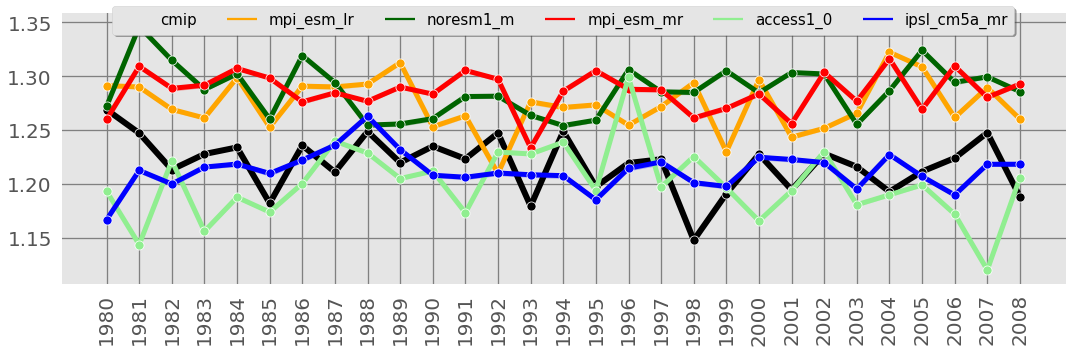

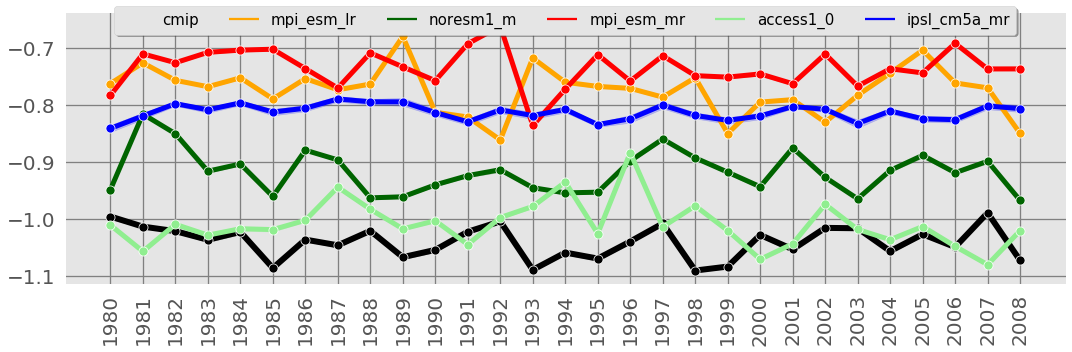

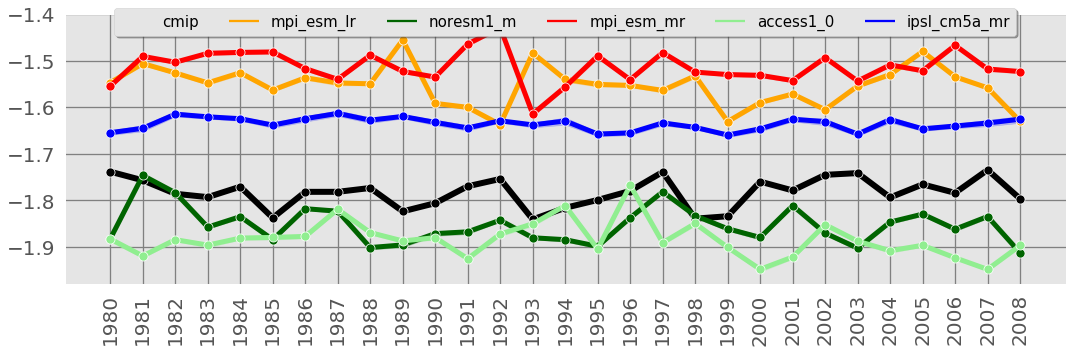

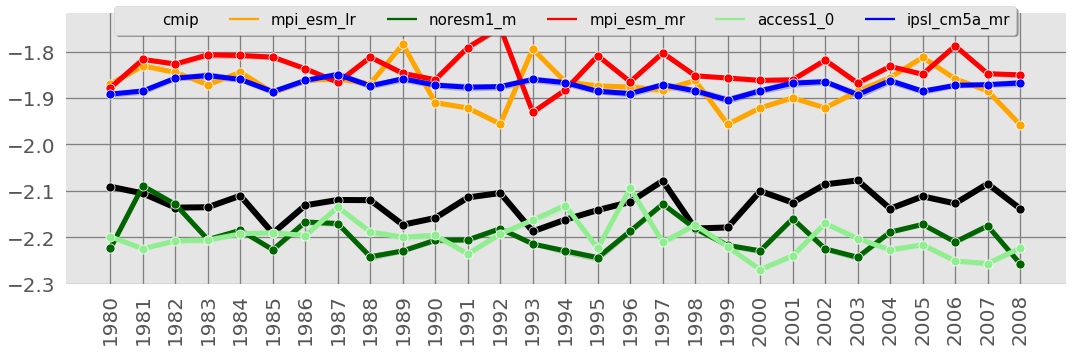

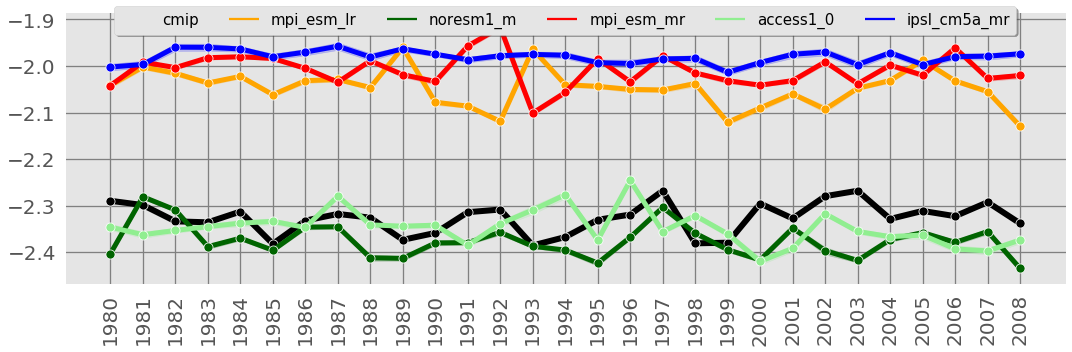

In [98]:
# extract results
base_model = 'ncep'
exp = 'amip'
results_df = get_entropy_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1'
]
normalized = True
results_df = post_processing_entropy(results_df, model=exp, exclude=exclude, normalized=normalized)

for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, ispatial, model=exp, save=True)

#### RCP

We want to extract the different CMIP models. The other parameters are constant for now.

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


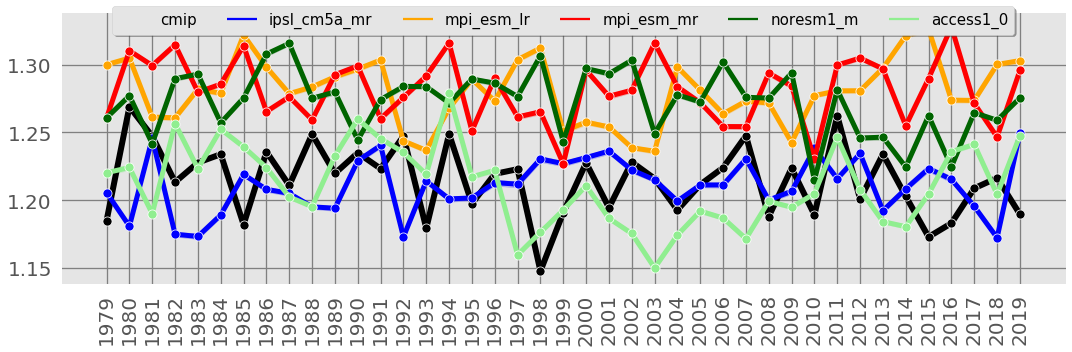

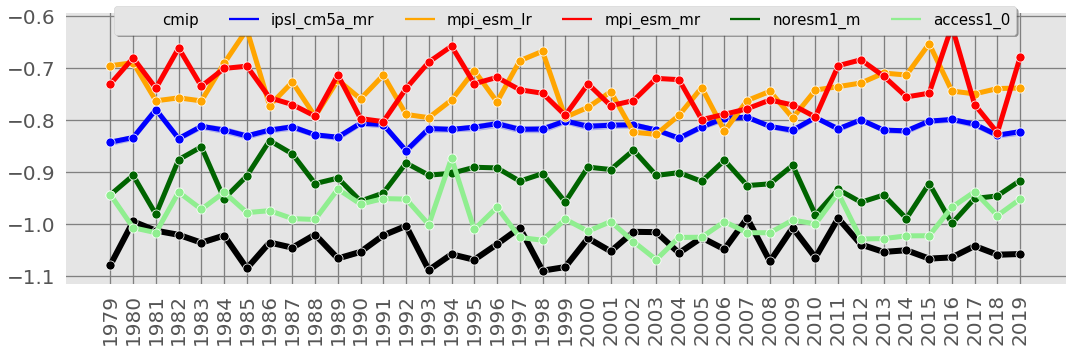

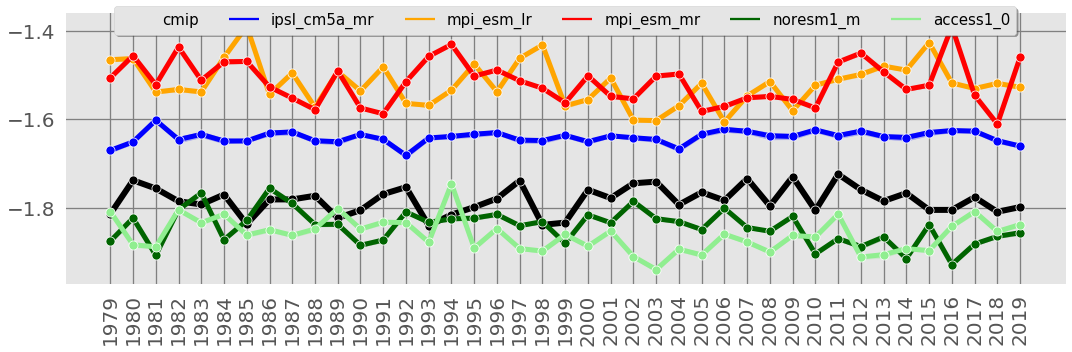

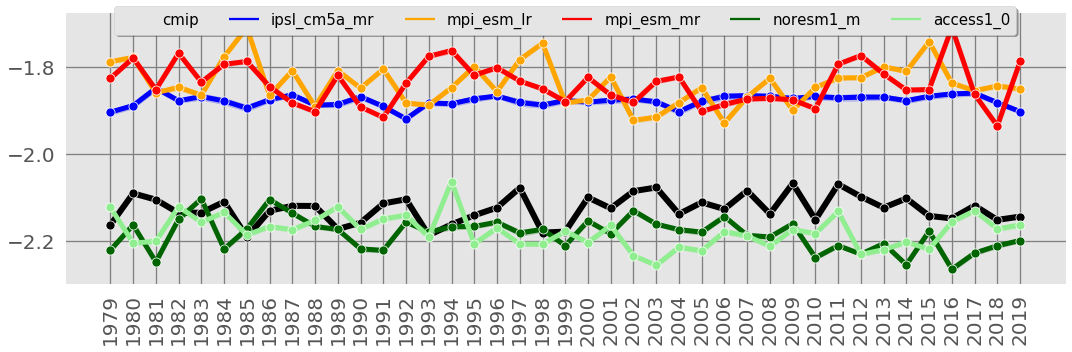

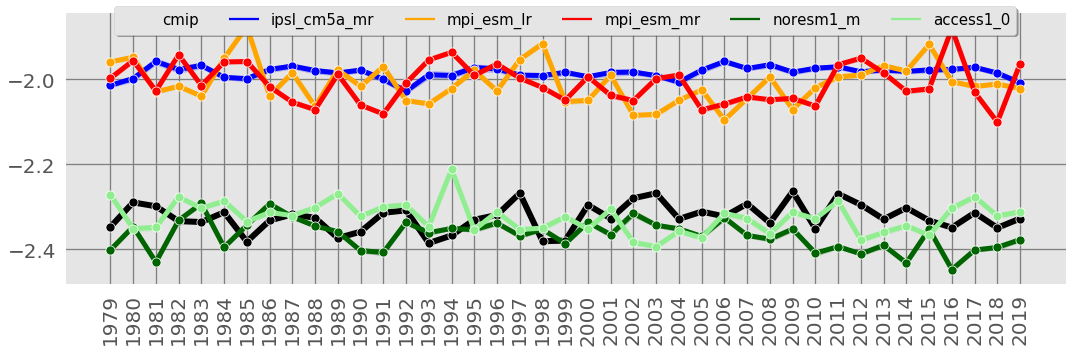

In [99]:
# extract results
base_model = 'ncep'
exp = 'rcp'
results_df = get_entropy_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1',
    'access1_3'
]

normalized = True
results_df = post_processing_entropy(results_df, model=exp, exclude=exclude, normalized=normalized)

for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, ispatial, model=exp, save=True)

### ERA5 - Individual IT Measures

#### AMIP

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


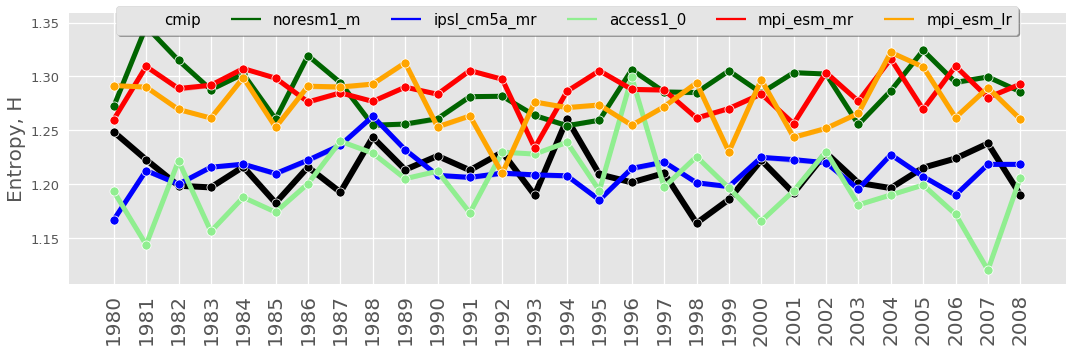

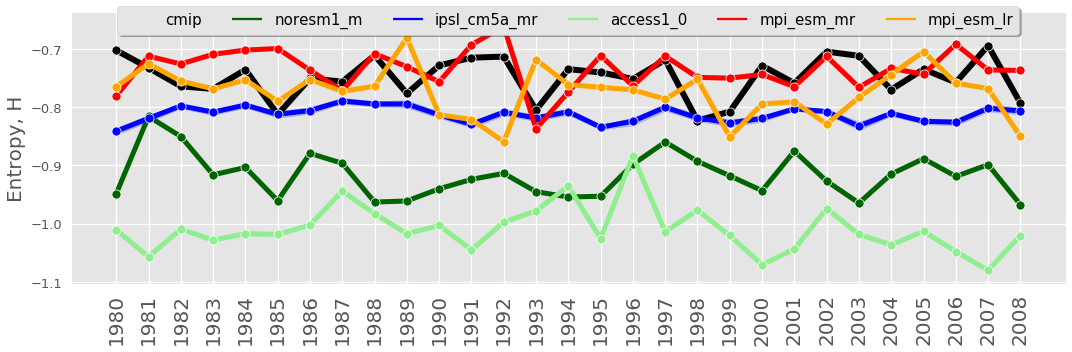

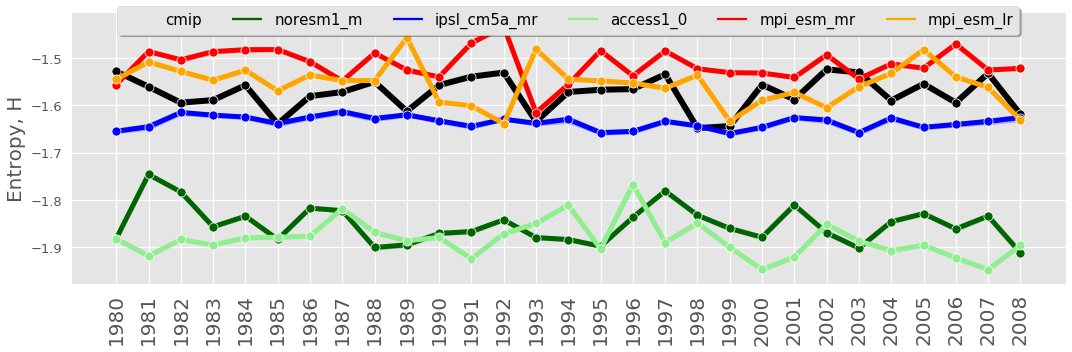

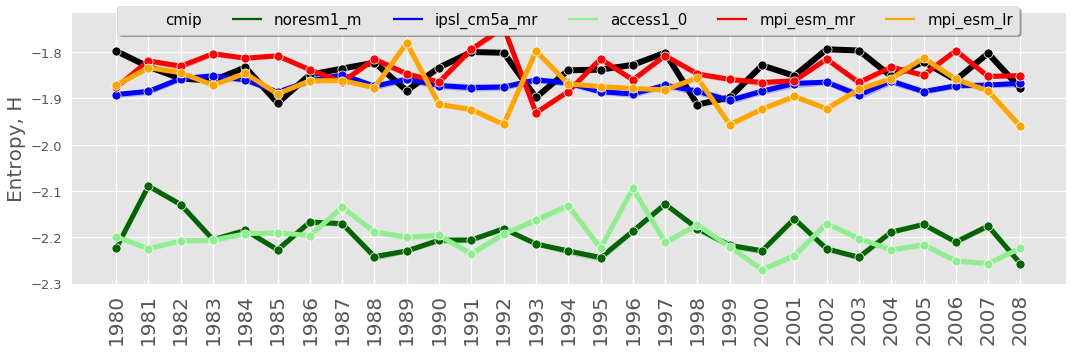

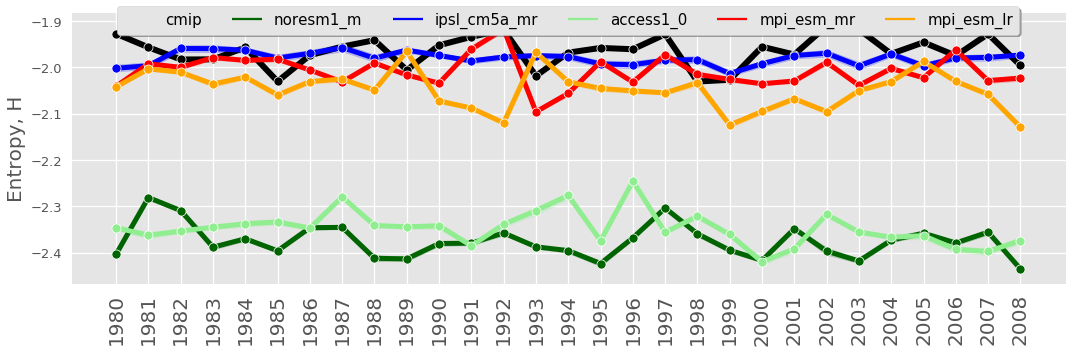

In [69]:
# extract results
base_model = 'era5'
exp = 'amip'
results_df = get_entropy_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1'
]

results_df = post_processing_entropy(results_df, model=exp, exclude=exclude)

for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, ispatial, model=exp, save=True)

#### RCP

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


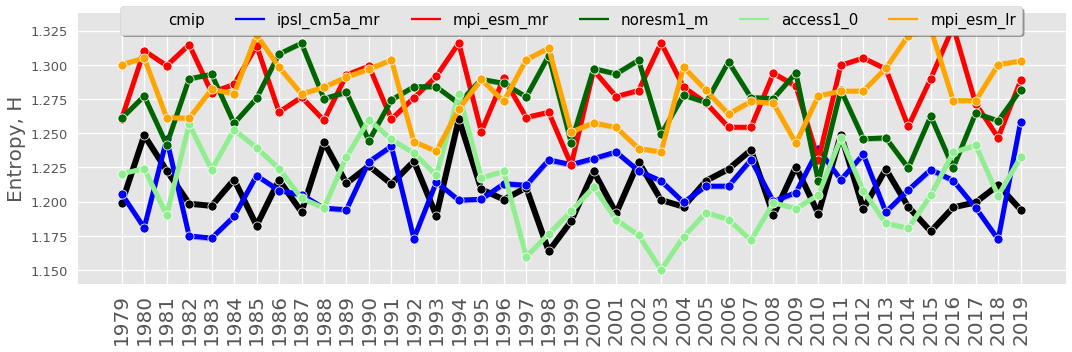

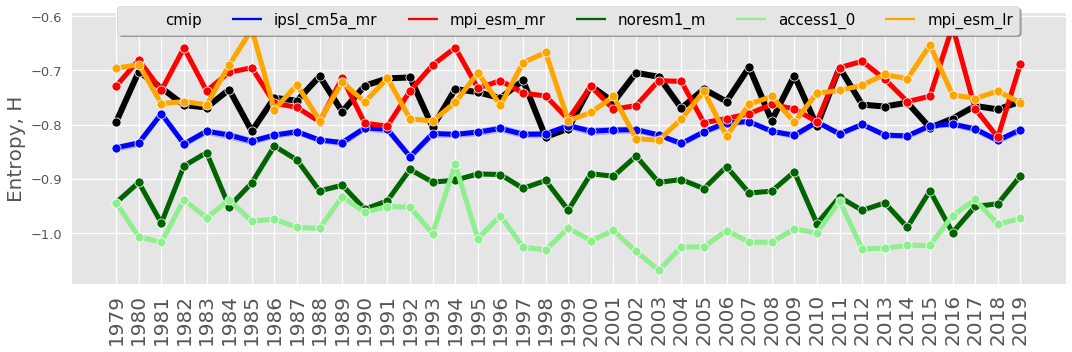

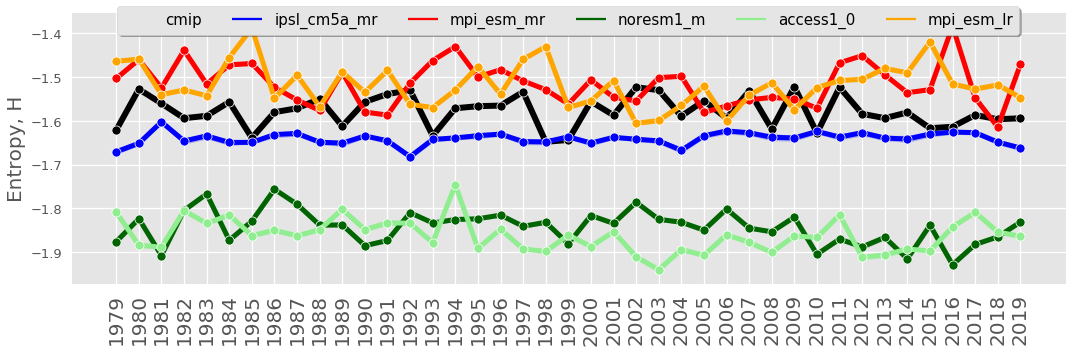

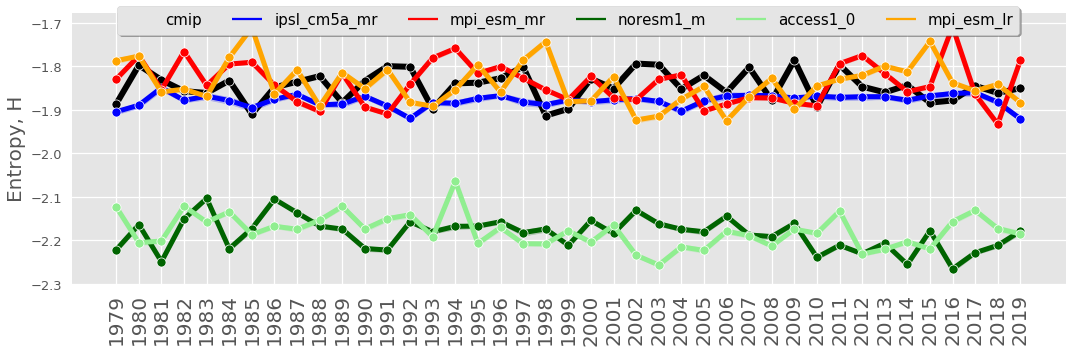

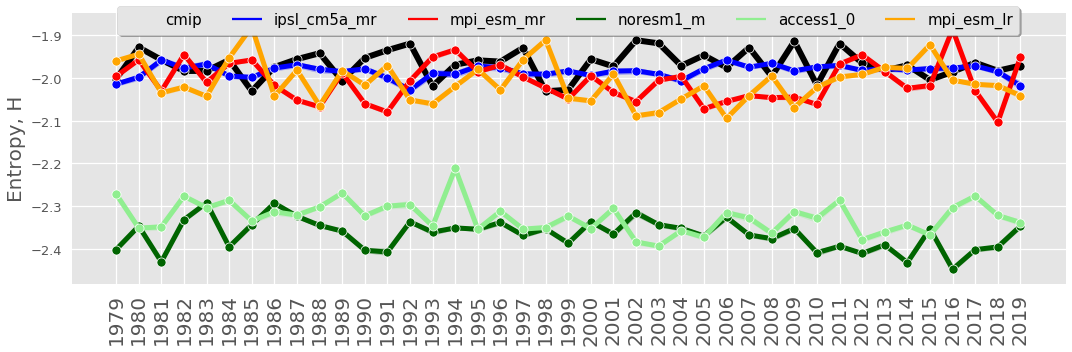

In [70]:
# extract results
base_model = 'era5'
exp = 'rcp'
results_df = get_entropy_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1',
    'access1_3'
]

results_df = post_processing_entropy(results_df, model=exp, exclude=exclude)

for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, ispatial, model=exp, save=True)

## Mutual Information


In [55]:
def get_mutual_info_results(base_model: str, results: str='interim', model: str='rcp')-> pd.DataFrame:
    base_path = '/home/emmanuel/projects/2020_rbig_rs/data/climate/'
    
    
    
    # CHECK: RCP or AMIP
    if model == 'rcp':
        data_path = f"/rcp/local/compare/"
    elif model == 'amip':
        data_path = f"/amip/local/compare/"
    else:
        raise ValueError('Unrecognized model: ', model)
        
#     print(base_path + results + data_path)
    path = Path(base_path + results + data_path)
    
    if base_model == 'ncep':
        filename_pattern = 'ncep_*_v3.csv'
        
    elif base_model == 'era5':
        filename_pattern = 'era5_*_v3.csv'
        
    else:
        raise ValueError('Unrecognized base model:', base_model)
    
    df_from_each_file = [pd.read_csv(f, index_col=0) for f in path.rglob(filename_pattern)]
    results_df   = pd.concat(df_from_each_file, ignore_index=True)
    return results_df

# def get_results_files_mi(base_model: str)-> pd.DataFrame:
    
#     path = Path(data_path)
    
#     if base_model == 'ncep':
#         filename_pattern = 'ncep_*_v3.csv'
        
#     elif base_model == 'era5':
#         filename_pattern = 'era5_*_v3.csv'
        
#     else:
#         raise ValueError('Unrecognized base model:', base_model)
    
#     df_from_each_file = [pd.read_csv(f, index_col=0) for f in path.rglob(filename_pattern)]
#     results_df   = pd.concat(df_from_each_file, ignore_index=True)
#     return results_df

from typing import List

def post_processing_mi(df: pd.DataFrame, info: str='h', exp: str='amip', exclude: List[str]=['inmcm4'], normalized: bool=True)-> pd.DataFrame:
    
#     # subset models
#     cmip_models = [
#         'mpi_esm_lr',
#         'noresm1_m',
# #         'inmcm4',
#         'mpi_esm_mr',
#         'access1_0',
#         'ipsl_cm5a_mr'
#     ]
    df = df[~df['cmip'].isin(exclude)]
    
    # divide by the spatial resolution
    if exp == 'amip':
        banned_cmip_dates = ['1979-01-16 12:00:00', '2009-01-16 12:00:00', '2010-01-16 12:00:00']
        banned_base_dates = ['1979-01-01', '2010-01-01']
    elif exp == 'rcp':
        banned_cmip_dates = ['2019-01-16 12:00:00']
        banned_base_dates = []
    else:
        raise ValueError('Unrecognized exp:', exp)
        
    if info == 'h':
        if normalized:
            df['h_base'] = df['h_base'] / (df['spatial'] ** 2)
            df['h_cmip'] = df['h_cmip'] / (df['spatial'] ** 2)
        else:
            pass
        
    elif info == 'mi':
        if normalized:
            df['mi'] = df['mi'] / (df['spatial'] ** 2)
        else:
            pass
        df = df[~df.cmip_time.isin(banned_cmip_dates)]
        df = df[~df.base_time.isin(banned_base_dates)]

    return df

In [87]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/interim/amip/local/compare/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/amip/local/compare/"

In [88]:
results_df.cmip.unique().tolist()

['mpi_esm_lr', 'access1_0']

### NCEP - Comparative IT Measures

#### AMIP

In [106]:
results_df.cmip.unique().tolist()

['mpi_esm_lr', 'ipsl_cm5a_lr', 'noresm1_m', 'mpi_esm_mr', 'access1_0']

In [107]:
results_df.head()

base   base_time        cmip            cmip_time kendelltau        mi  \
3220  ncep  1980-01-01  mpi_esm_lr  1980-01-16 12:00:00   0.599945  0.746869   
3221  ncep  1980-01-01  mpi_esm_lr  1980-01-16 12:00:00   0.591253  0.694736   
3222  ncep  1980-01-01  mpi_esm_lr  1980-01-16 12:00:00   0.584682   0.71889   
3223  ncep  1980-01-01  mpi_esm_lr  1980-01-16 12:00:00   0.598413  0.716736   
3224  ncep  1980-01-01  mpi_esm_lr  1980-01-16 12:00:00    0.59382  0.706751   

       pearson spatial  spearman subsample  time_mi trial variable  
3220  0.791773       1  0.748195     10000  1.75668     0      psl  
3221  0.787028       1  0.740457     10000  1.83795     1      psl  
3222  0.780007       1  0.729812     10000  2.21417     2      psl  
3223  0.783515       1  0.745998     10000  1.94358     3      psl  
3224  0.787425       1  0.743049     10000  1.97115     4      psl

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


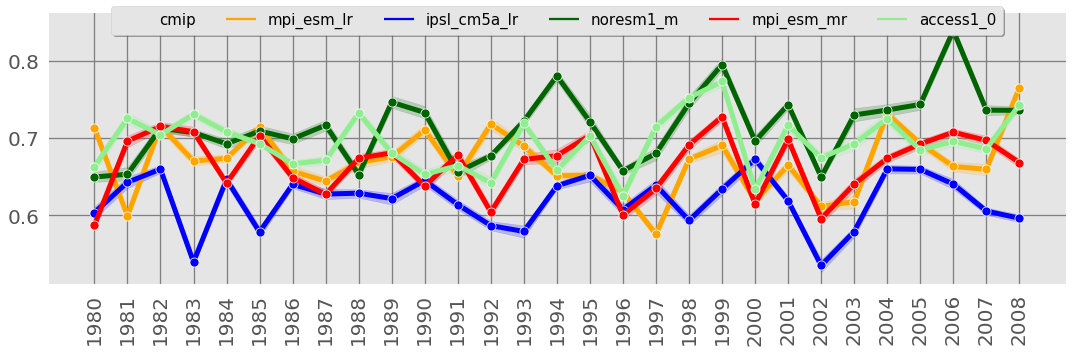

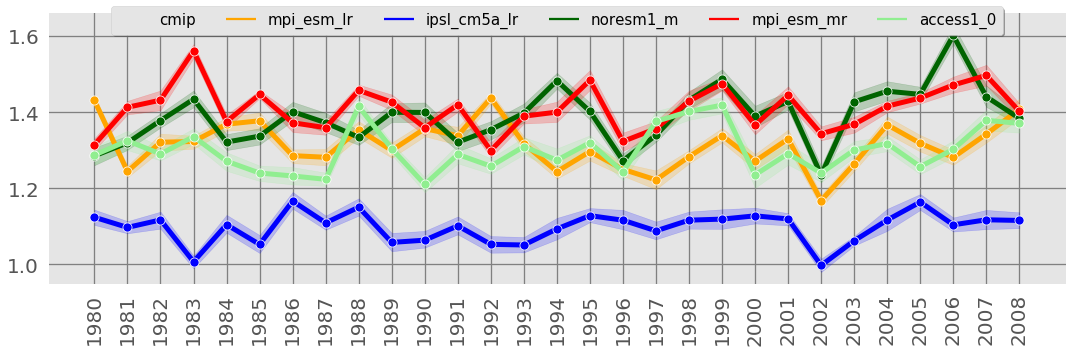

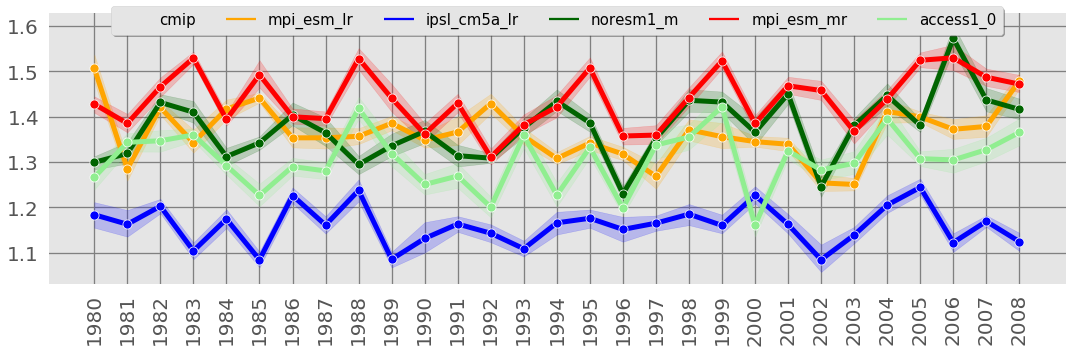

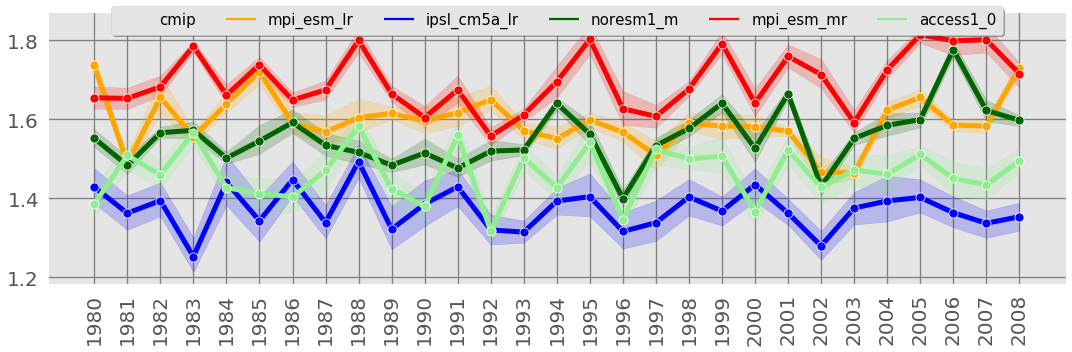

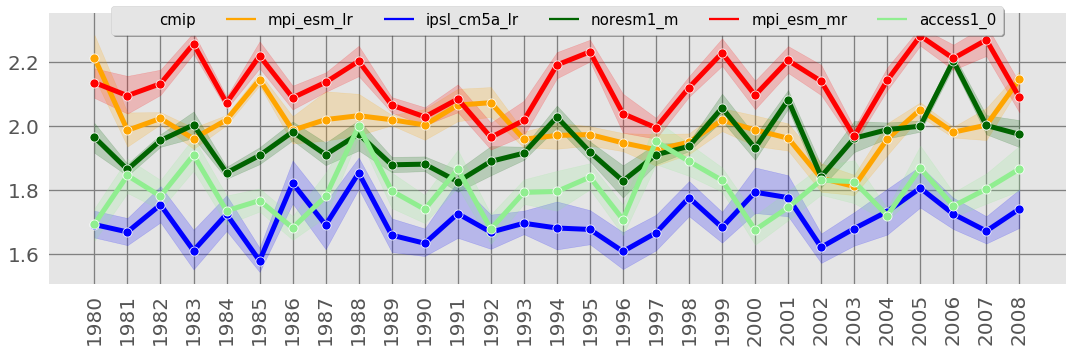

In [110]:
# extract results
base_model = 'ncep'
exp = 'amip'
results_df = get_mutual_info_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1'
]
normalized = False
results_df = post_processing_mi(results_df, info='mi', exclude=exclude, normalized=normalized)
results_df.cmip[results_df['cmip'] == 'cnrm_cm5'] = 'mpi_esm_mr'


for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, spatial_res=ispatial, info='mi',  model=exp, save=True)


#### RCP

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


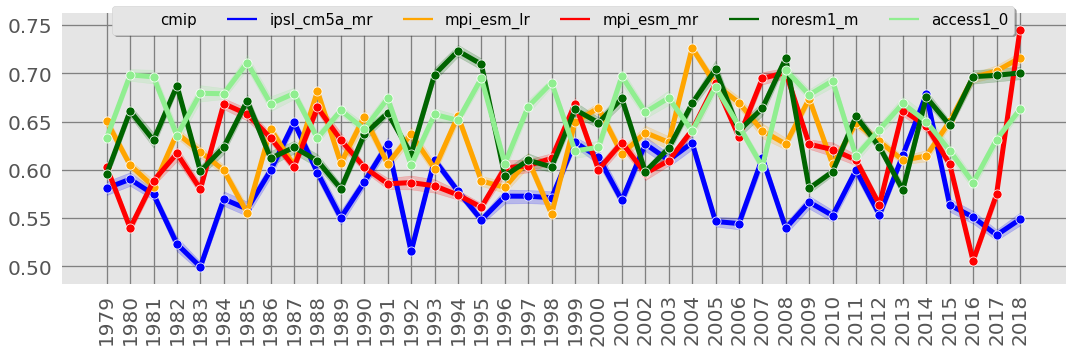

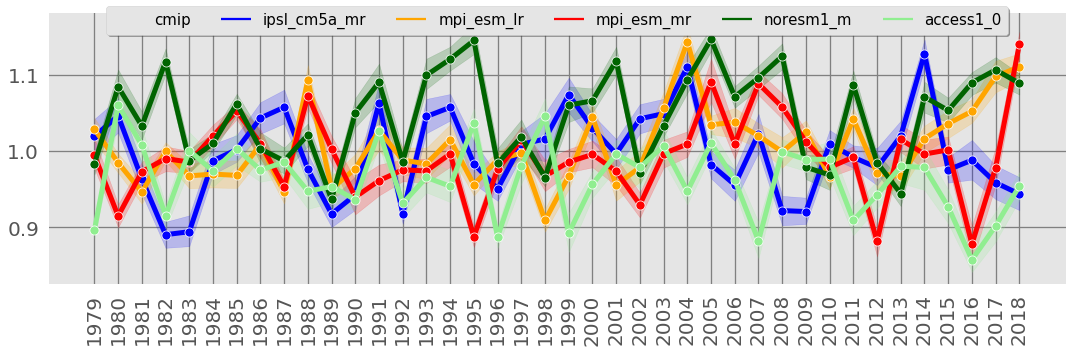

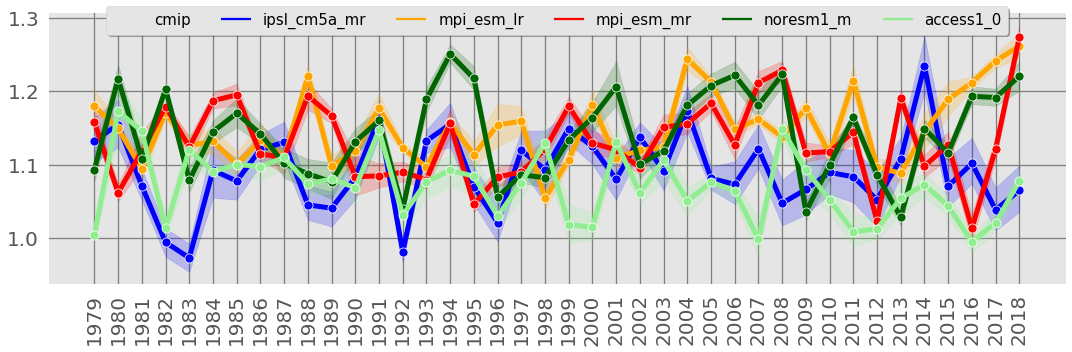

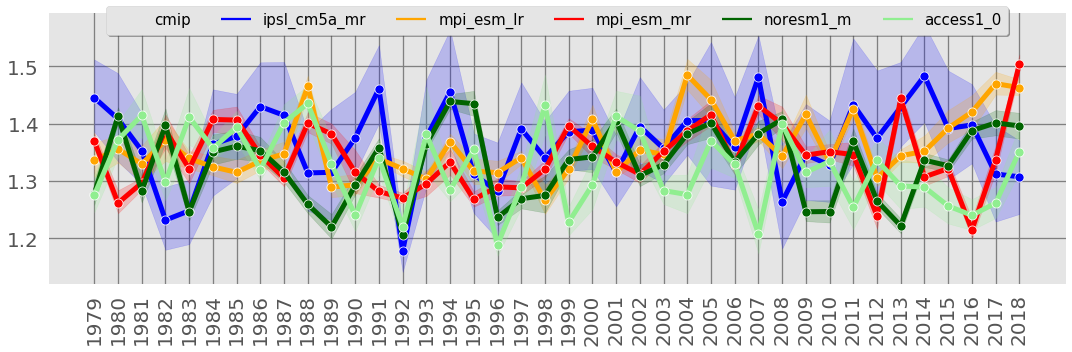

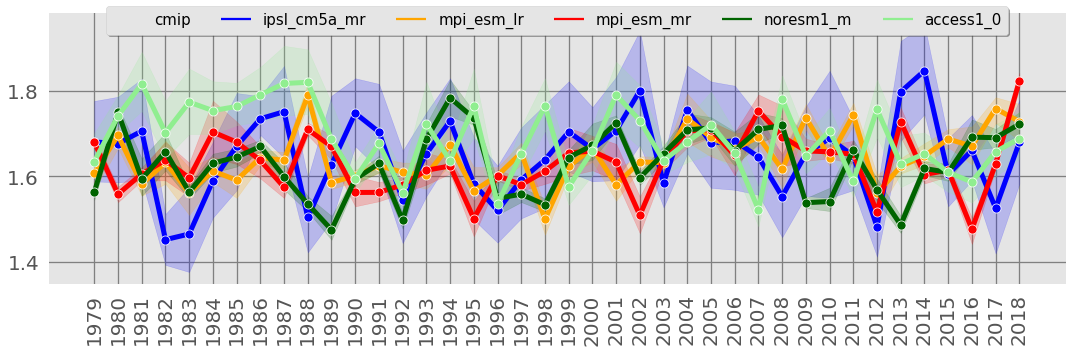

In [111]:
# extract results
base_model = 'ncep'
exp = 'rcp'
results_df = get_mutual_info_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1',
    'access1_3'
]
normalized = False
results_df = post_processing_mi(results_df, info='mi', exclude=exclude, exp=exp, normalized=normalized)
results_df.cmip[results_df['cmip'] == 'cnrm_cm5'] = 'mpi_esm_mr'


for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, spatial_res=ispatial, info='mi',  model=exp, save=True)

### ERA5 - Comparative IT Measures

#### AMIP

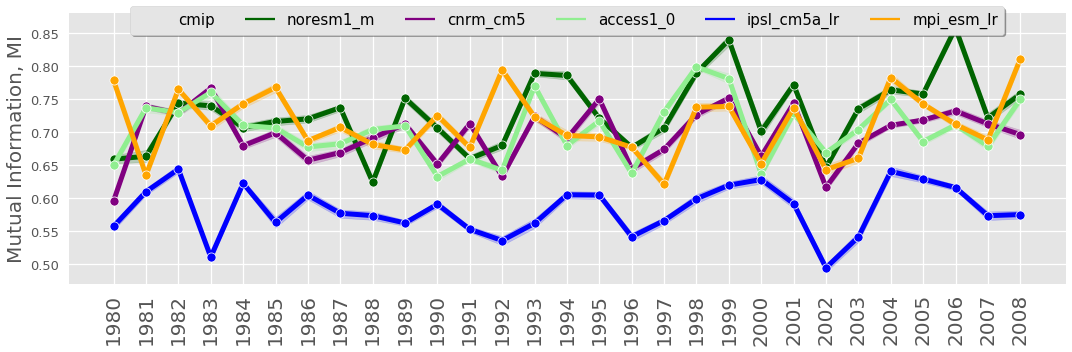

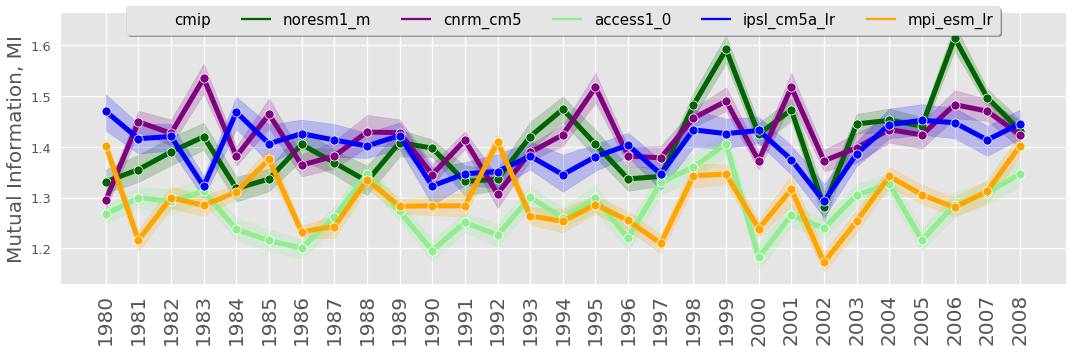

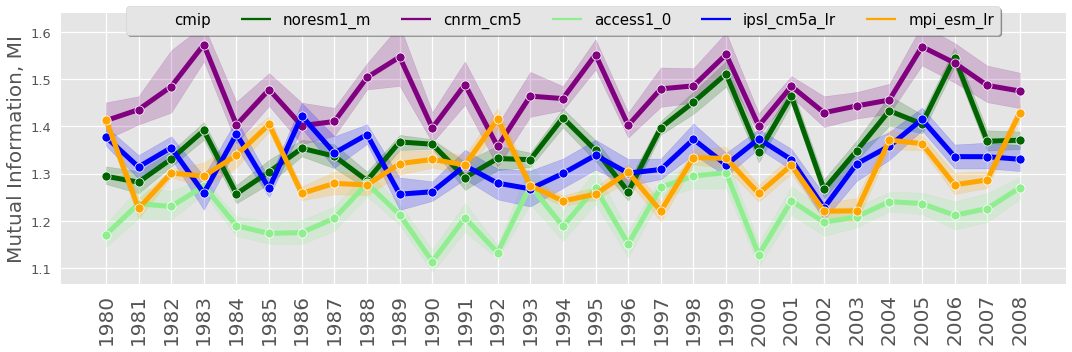

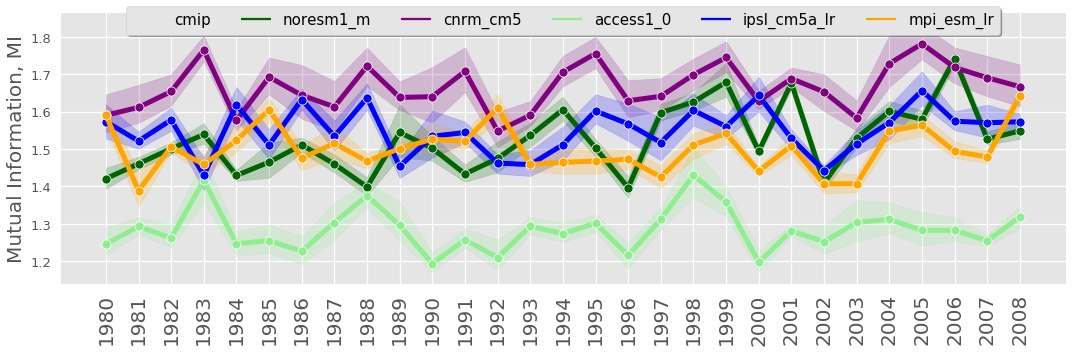

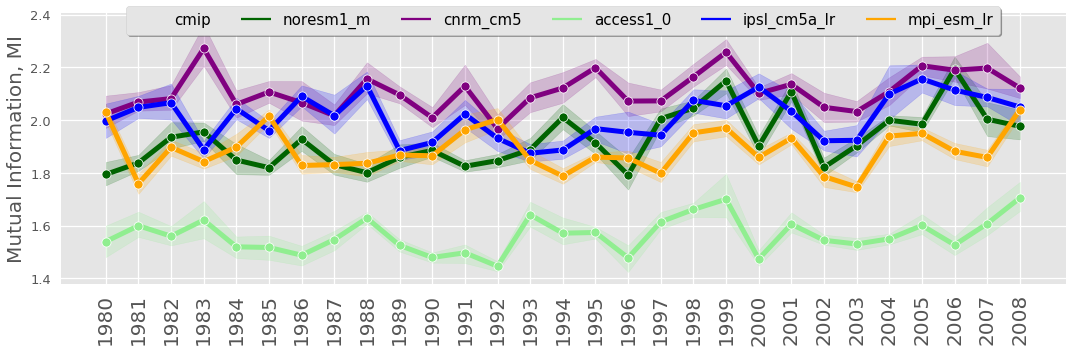

In [65]:
# extract results
base_model = 'era5'
exp = 'amip'
results_df = get_mutual_info_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1'
]
normalized = False
results_df = post_processing_mi(results_df, info='mi', exclude=exclude, normalized=normalized)

for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, spatial_res=ispatial, info='mi',  model=exp, save=True)

#### RCP

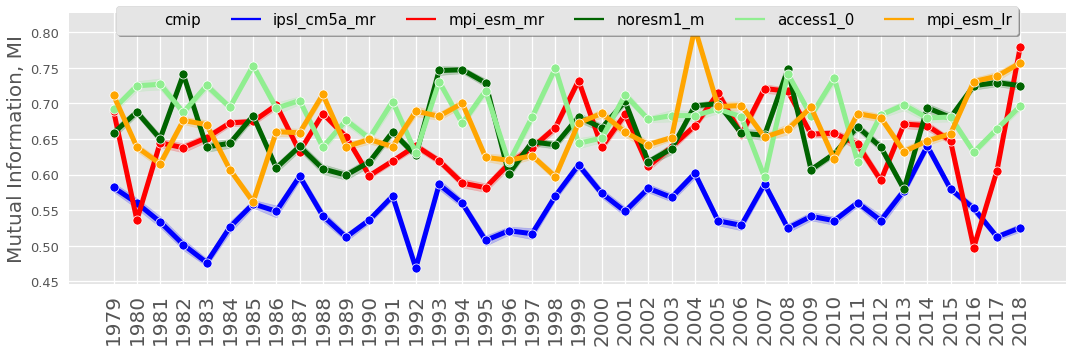

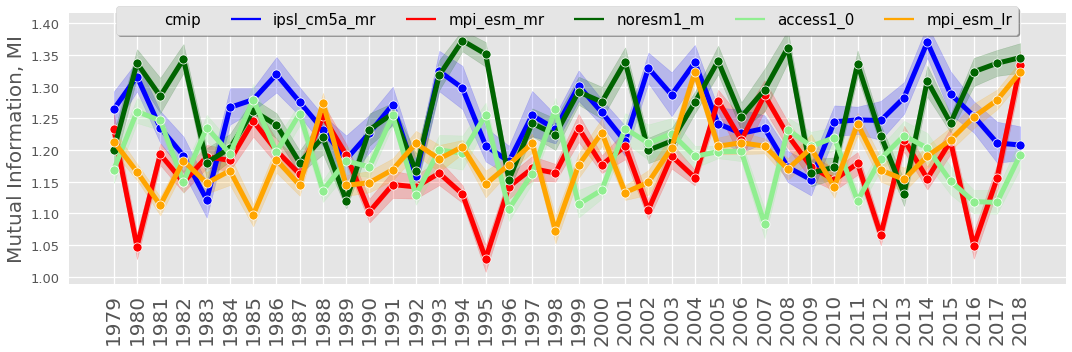

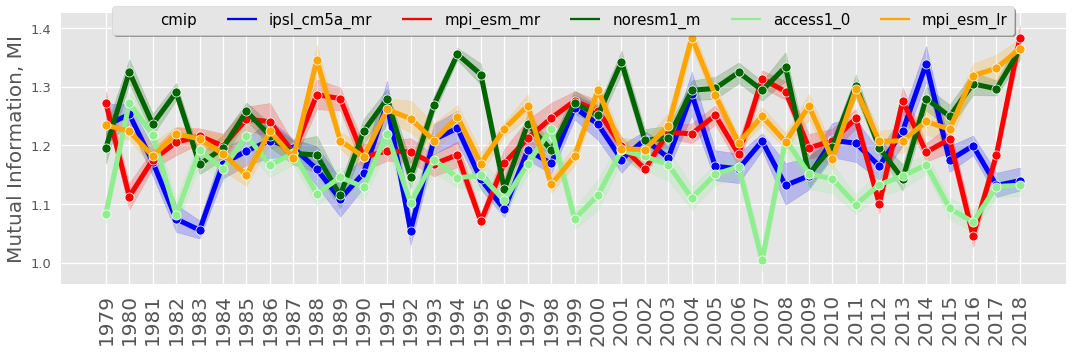

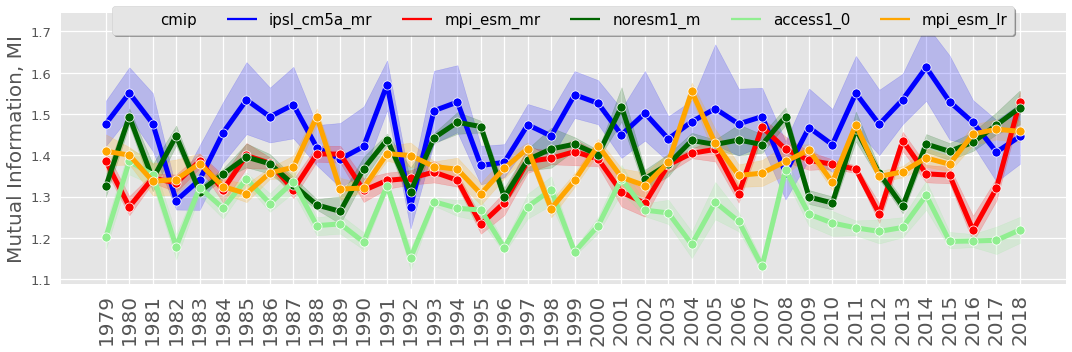

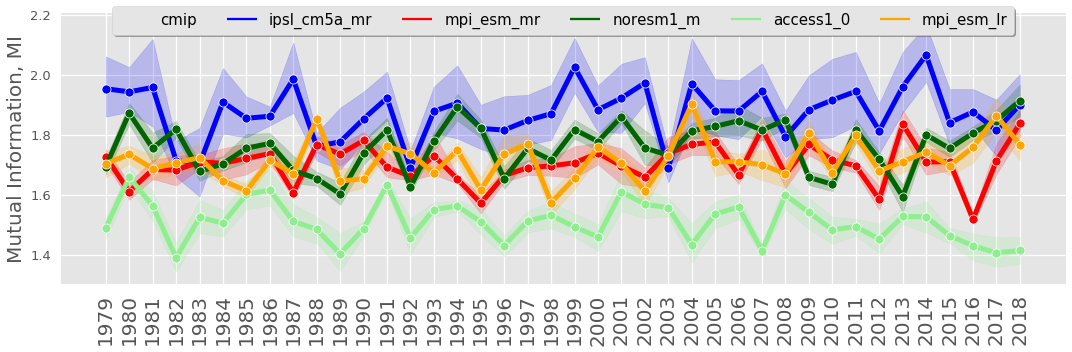

In [66]:
# extract results
base_model = 'era5'
exp = 'rcp'
results_df = get_mutual_info_results(
    base_model, 
    results='results', 
    model=exp
)

# post processing
exclude = [
    'inmcm4',
    'giss_e2_r',
    'bnu_esm',
    'bcc_csm1_1',
    'access1_3'
]
normalized = False
results_df = post_processing_mi(results_df, info='mi', exclude=exclude, normalized=normalized, exp=exp)

for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_individual_all(results_df, base_model, spatial_res=ispatial, info='mi',  model=exp, save=True)